Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train loss: 0.05169946555498133, accuracy: 0.98171909924589
Validation loss: 0.039938481736187276, accuracy: 0.9840566087001932
Epoch 2/3
Train loss: 0.03372935149146134, accuracy: 0.9865001775605272
Validation loss: 0.039482025861964545, accuracy: 0.9846467178442738
Epoch 3/3
Train loss: 0.02661377561046613, accuracy: 0.9892419209960102
Validation loss: 0.042703513892483315, accuracy: 0.9851010496631678
Model saved to model/bert_toxic_model2.pth


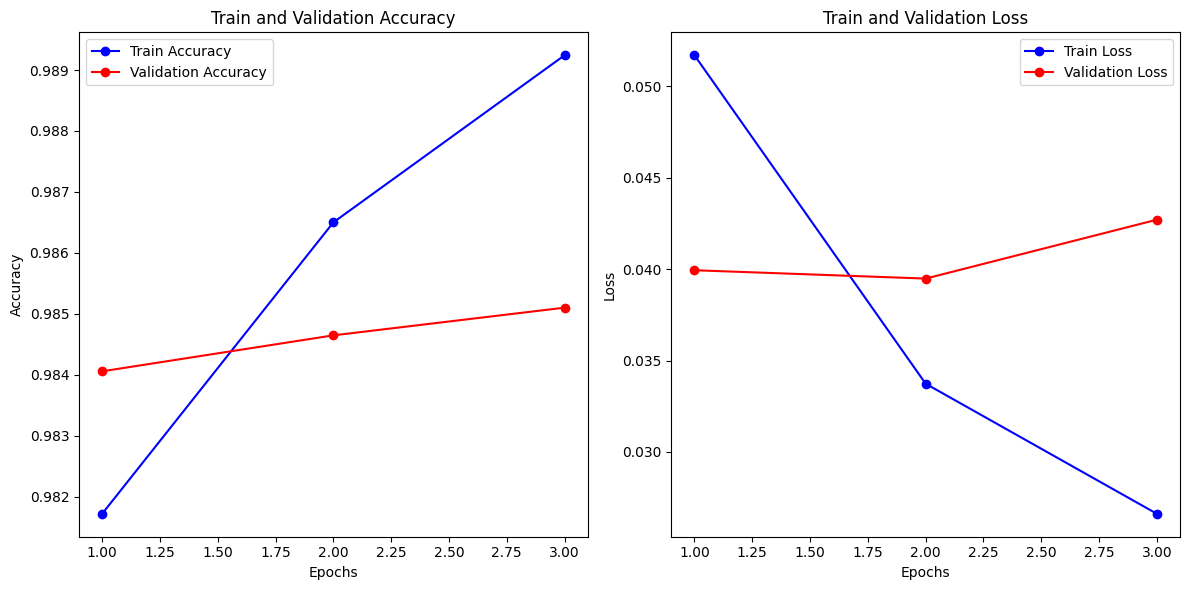

Classification Report for toxic:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     28859
         1.0       0.86      0.80      0.83      3056

    accuracy                           0.97     31915
   macro avg       0.92      0.89      0.91     31915
weighted avg       0.97      0.97      0.97     31915



Classification Report for severe_toxic:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     31594
         1.0       0.54      0.42      0.47       321

    accuracy                           0.99     31915
   macro avg       0.77      0.71      0.73     31915
weighted avg       0.99      0.99      0.99     31915



Classification Report for obscene:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     30200
         1.0       0.87      0.78      0.82      1715

    accuracy                           0.98     31915
   macro avg    

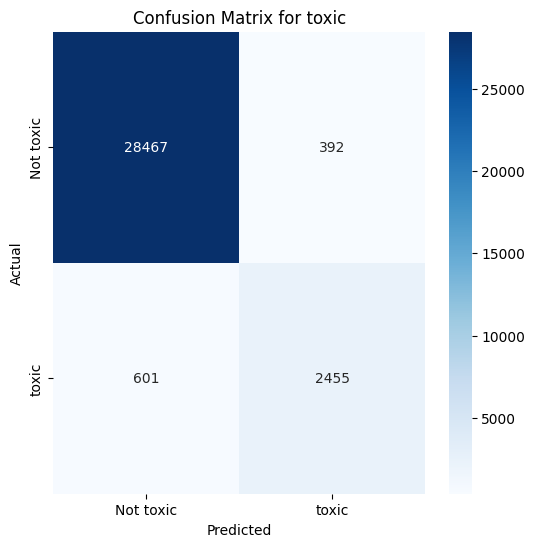

Confusion Matrix for severe_toxic:


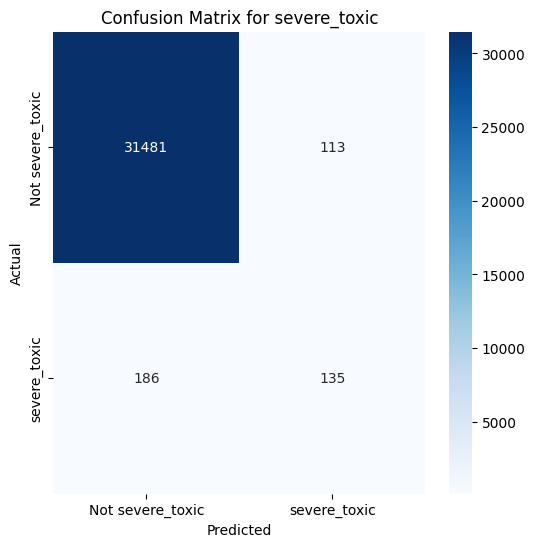

Confusion Matrix for obscene:


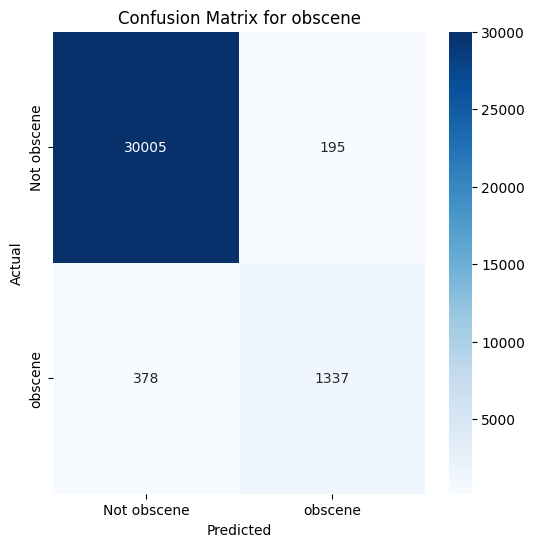

Confusion Matrix for threat:


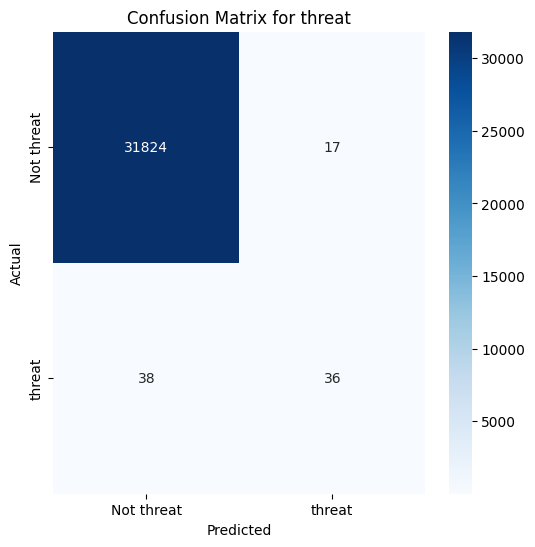

Confusion Matrix for insult:


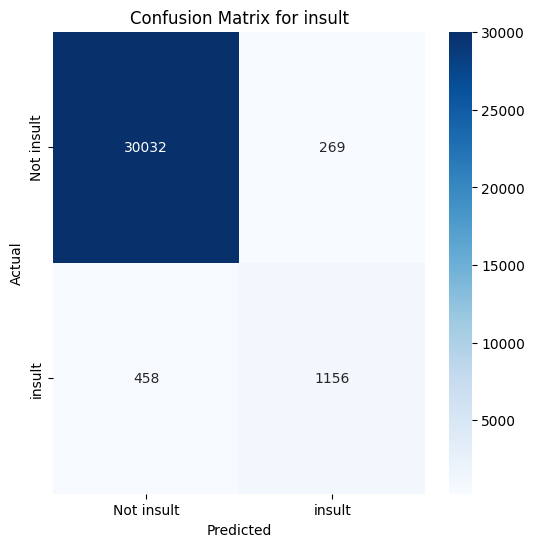

Confusion Matrix for identity_hate:


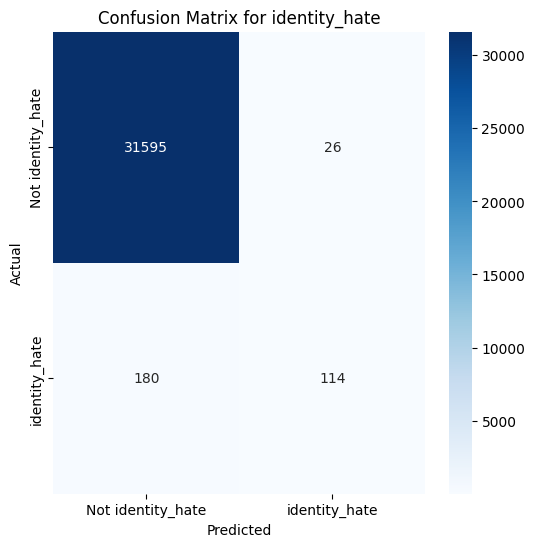

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_SAVE_PATH = 'model/bert_toxic_model.pth'

df = pd.read_csv('data/train.csv')
# df = df.sample(frac=0.4, random_state=42)
comments = df['comment_text'].values
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_train, X_val, y_train, y_val = train_test_split(comments, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class CommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

train_dataset = CommentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = CommentDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss().to(device)


def train_epoch(model, data_loader, optimizer, criterion, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        
        correct_predictions += ((outputs.logits.sigmoid() > 0.5).float() == labels).sum().item()
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return correct_predictions / (len(data_loader.dataset) * labels.size(1)), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            
            correct_predictions += ((outputs.logits.sigmoid() > 0.5).float() == labels).sum().item()
            losses.append(loss.item())
    
    return correct_predictions / (len(data_loader.dataset) * labels.size(1)), np.mean(losses)


history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc, val_loss = eval_model(model, val_loader, criterion, device)
    
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, accuracy: {val_acc}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f'Model saved to {MODEL_SAVE_PATH}')



# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Function to plot metrics
def plot_metrics(history):
    epochs = range(1, EPOCHS + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')
    
    plt.tight_layout()
    plt.show()

# Function to get classification report
def get_classification_report(model, data_loader, device, class_names):
    model = model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = (outputs.logits.sigmoid() > 0.5).cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Print classification report for each label
    for i, label_name in enumerate(class_names):
        print(f"Classification Report for {label_name}:")
        print(classification_report(all_labels[:, i], all_preds[:, i], zero_division=0))
        print("\n")

# Function to plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds, class_name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + class_name, class_name], yticklabels=['Not ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()

# Collect all labels and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for d in val_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = (outputs.logits.sigmoid() > 0.5).cpu().numpy()

        all_labels.extend(labels)
        all_preds.extend(preds)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Plot metrics
plot_metrics(history)

# Get classification report
get_classification_report(model, val_loader, device, class_names)

# Plot confusion matrix for each class
for i, class_name in enumerate(class_names):
    print(f"Confusion Matrix for {class_name}:")
    plot_confusion_matrix(all_labels[:, i], all_preds[:, i], class_name)


